In [ ]:
import numpy as np
from sklearn import svm
import seaborn as sns
from matplotlib import pyplot as plt

#!pip install bayesian-optimization
#!pip install torch
#!pip install pyro

# 1 Business Understanding

Der Datensatz unserer Challenge befasst sich mit der Analyse und dem Vorhersagen von Herzinfarkten. Durch die Analyse von verschiedenen Patientendaten soll frühzeitig ein hohes Herzinfarktrisiko vorhergesagt werden. Dadurch kann rechtzeitig mit einer Behandlung zur Prävention begonnen werden. 

Kein besonderer Fokus wurde auf die benötigten Ressourcen der künstlichen Intelligenz gelegt. Dies liegt daran, dass ein Menschenleben nicht mit den Ressourcen abzuwiegen ist. Aus diesem Grund geht ebenfalls heraus, dass jedes Prozent der Genauigkeit wichtig ist. Außerdem ist kein besonders hoher Wert auf die Performance der Durchlaufzeit oder ähnlichen Werten gelegt. Aus Darstellungsgründen wurden jedoch an einigen Stellen Annahmen und Vereinfachungen eingebaut.

Ein besonderer Fokus der Berechnung soll darauf liegen, dass möglichst wenige Herzinfarkte unentdeckt bleiben. 

# 2 Data Understanding


## 2.1 Collect Initial Data

Link zum Datensatz: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [ ]:
import pandas as pd
# Datenset laden
fulldata = pd.read_csv("heart.csv")

## 2.2 Describe Data

In [ ]:
fulldata

In [ ]:
fulldata.columns

Folgende Variablenerklärungen liefert der Datensatz

|Variable|Erklärung|Anmerkung|
|:---|:---|:---|
age|Age of the patient|
sex|Sex of the patient|keine Erklärung, welches Geschlecht wie kodiert ist
cp|Chest Pain type chest pain type|Value 1: typical angina<br>Value 2: atypical angina<br>Value 3: non-anginal pain<br>Value 4: asymptomatic
trtbps|resting blood pressure (in mm Hg)|Ruheblutdruck
chol|cholestoral in mg/dl fetched via BMI sensor|Cholesterinspiegel
fbs|(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|Erhöhter Blutzucker
restecg|resting electrocardiographic results|Value 0: normal<br>Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)<br>Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalachh|maximum heart rate achieved|Maximaler Puls
exng|exercise induced angina (1 = yes; 0 = no)|Engegefühl in der Brust bei körperlicher Belastung
oldpeak|keine Erklärung vorhanden|
slp|keine Erklärung vorhanden|
caa|number of major vessels (0-3)|weglassen, da Beschreibung uneindeutig, Skala passt auch nicht [0-3] 
thall|keine Erklärung vorhanden|
output|0 = less chance of heart attack, 1 = more chance of heart attack

Für die Spalten ``oldpeak``, ``slp`` und ``thall`` existieren keine Erklärungen.

In [ ]:
fulldata.thall.unique()

Nach weiterer Recherche können folgende Vermutungen aufgestellt werden. 

Die Spalte ``thall`` bezieht sich auf die Form der Thalssämie. Dabei stehen die Werte 1-3 für die Art der Krankheit, wohingegen die 0 kein Vorhandensein der Krankheit abbildet.  <br> 
<a href="https://www.netdoktor.de/krankheiten/thalassaemie/#:~:text=Die%20Thalass%C3%A4mie%20oder%20Mittelmeeran%C3%A4mie%20ist,Alpha%2D%20und%20Beta%2DThalass%C3%A4mie.">Quelle 1</a>
<br>
<a href="https://www.kinderblutkrankheiten.de/erkrankungen/rote_blutzellen/anaemien_blutarmut/thalassaemie/krankheitsformen/">Quelle 2</a> <br>

In [ ]:
fulldata.slp.unique()

Die Spalte ``slp`` ist die Abkürzung für Slope. Dieser Wert wird beim Auswerten eines EKGs benutzt (<a href="https://pubmed.ncbi.nlm.nih.gov/18269981/">Quelle</a>). Die genaue Kodierung der Daten ist unbekannt.

In [ ]:
fulldata.oldpeak.unique()

Für die Spalte ``oldpeak`` wurde keine Erklärung gefunden. 

## 2.3 Explore Data

In [ ]:
fulldata.isnull().sum()
#keine fehlenden Daten vorhanden

In [ ]:
fulldata.describe()

Der Anteil zu gefährdeten und nicht gefährdeten Personen liegt bei circa 50%.

In [ ]:
sns.displot(fulldata['age']);

In [ ]:
_ = sns.pairplot(fulldata, corner=True)

In [ ]:
_ = sns.pairplot(fulldata, hue="output", corner=True)

Durch die beiden Pairplots sind keine einfachen Korrelationen der Variablen ersichtlich.

In [ ]:
#correlation matrix
corrmat = fulldata.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, cmap="binary", linewidths=1);

In [ ]:
corrmat.max()

Auch durch weitere Berechnung wird keine deutliche Korrelation zweier Variablen deutlich.

# 3 Data Preparation

## 3.1 Select Data

Innerhalb des Data Understandings sind unerklärte Spalten entdeckt worden. Da der Datensatz in sich geschlossen ist und keine willkürlichen Daten beinhaltet, können die Daten weiter benutzt werden. Hierdurch wird die Anzahl der verfügbaren Daten möglichst hoch gehalten. In einer realen Anwendung des Algorithmus muss das Data Understanding mit weiterem Fachwissen durchgeführt werden, um die Daten besser zu analysieren und hierdurch bessere Ergebnisse zu berechnen. 

## 3.2 Data Cleaning

Da mit einem sauberen Datensatz begonnnen wird ist eine separate Datenbereinigung nicht notwendig. 

## 3.3 Construct Data

Es werden keine zusätzlichen Berechnungen zur Generierung weiterer Daten durchgefüht.

## 3.4 Integrate Data

Es werden keine weiteren Daten hinzugefügt.

## 3.5 Format Data

In [3]:
# Datentypen anpassen
cols = [
    "sex",
    "cp",
    "restecg",
    "slp",
    "caa",
    "thall"
]

for col in cols:
    fulldata[col] = fulldata[col].astype("category")
    
cols = [
    "fbs",
    "exng",
     "output"
]

for col in cols:
    fulldata[col] = fulldata[col].astype("bool")

In [4]:
#data = fulldata.drop(["oldpeak", "slp", "caa", "thall", "output"], axis=1)
#data = fulldata.drop(['cp', 'restecg', 'output'], axis=1)
data = fulldata.drop(['output'], axis=1)
output = fulldata['output']
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [5]:
from sklearn.model_selection import train_test_split

# load data
X, y = data, output

# split the data into 2 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(227, 13) (227,)
(76, 13) (76,)


# 4 Modeling

In [6]:
from sklearn.model_selection import cross_val_score

result_array = []
# warum keine precomputed method?
methods = ["linear", "poly", "rbf", "sigmoid"]
k = 10
for i, element in enumerate(methods):
    method = methods[i] 
    clf = svm.SVC(kernel=method, C=1)
    scores = cross_val_score(clf, data, output, cv=k)
    result_array.append((scores.mean(), method))
result_array

[(0.8348387096774192, 'linear'),
 (0.663763440860215, 'poly'),
 (0.6604301075268817, 'rbf'),
 (0.5411827956989248, 'sigmoid')]

In [7]:


param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']}]

from sklearn.model_selection import GridSearchCV

# create a SVC and optimize it with a grid search
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(data, output)

# get the best estimator
clf.best_estimator_

SVC(C=1, kernel='linear')

In [8]:
k = 10
clf = svm.SVC(kernel="linear", C=1)
scores = cross_val_score(clf, data, output, cv=k)
scores.mean()

0.8348387096774192

In [9]:
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [10]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_test_scaled = scaler.transform(np.array(X_test))
# Define the black box function to optimize.

def black_box_function(C):
    k=10
    model = svm.SVC(kernel="linear", C=C)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, data, output, cv=k)
    f = scores.mean()
    return f
def black_box_function_onlyscore(C):
    # C: SVC hyper parameter to optimize for.
    #model = SVC(C = C, kernel="linear" )
    
    model = svm.SVC(kernel="linear", C=C)
    model.fit(X_train, y_train)
    
    #from sklearn.metrics import accuracy_score 
    #fulldata["predicted"] = model.predict(data) 
    #f = accuracy_score(y_true = fulldata["output"], y_pred = fulldata["predicted"])
    #model.fit(X_train_scaled, y_train)
    #model.fit(X_train, y_train)
    #y_score = model.decision_function(X_test_scaled)
    #y_score = model.decision_function(X_test)
    #f = roc_auc_score(y_test, y_score)
    #y_score = model.decision_function(X_test)
    f = model.score(X_test, y_test)
    return f

def black_box_functionorigi(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C, kernel="linear", random_state=42 )
    
    #model.fit(X_train_scaled, y_train)
    model.fit(X_train, y_train)
    #y_score = model.decision_function(X_test_scaled)
    y_score = model.decision_function(X_test)
    f = roc_auc_score(y_test, y_score)
    #y_score = model.decision_function(X_test)
    #f = model.score(X_train, y_train)
    return f
# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"C": [1, 100]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer_acc = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2
                                 )
optimizer_acc.maximize(init_points = 10, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer_acc.max["params"], optimizer_acc.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.8317   |  94.64    |
|  2        |  0.8216   |  50.74    |
|  3        |  0.8248   |  50.06    |
|  4        |  0.8217   |  48.76    |
|  5        |  0.8216   |  39.47    |
|  6        |  0.8348   |  4.39     |
|  7        |  0.8183   |  30.85    |
|  8        |  0.8349   |  91.68    |
|  9        |  0.8184   |  65.9     |
|  10       |  0.8318   |  99.2     |
|  11       |  0.8316   |  93.0     |
|  12       |  0.8348   |  2.743    |
|  13       |  0.8351   |  89.62    |
|  14       |  0.8383   |  86.97    |
|  15       |  0.8351   |  84.8     |
|  16       |  0.8382   |  7.745    |
|  17       |  0.8282   |  10.22    |
|  18       |  0.8448   |  81.28    |
|  19       |  0.8383   |  79.51    |
|  20       |  0.8384   |  82.53    |
Best result: {'C': 81.28215524449597}; f(x) = 0.8448387096774195.


In [11]:
optimizer_acc.max["params"].get("C")

81.28215524449597

In [12]:
k=10
model = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"))
model.fit(X_train, y_train)
scores = cross_val_score(model, data, output, cv=k)
scores.mean()

0.8448387096774195

In [22]:
k=10
testmodel = svm.SVC(C = 1, kernel = "linear")
testmodel.fit(X_train, y_train)
testscores = cross_val_score(testmodel, data, output, cv=k)
testscores.mean()

0.8348387096774192

In [13]:
scores


array([0.87096774, 0.77419355, 0.90322581, 0.93333333, 0.86666667,
       0.86666667, 0.83333333, 0.9       , 0.73333333, 0.76666667])

## False Negatives verringern
### Überblick verschaffen
Für unseren Anwendungsfall sind False Negatives besonders fatal, weshalb sie möglichst gering sein soll.

Als False Negatives werden Ergebnisse bezeichnet, die als fälschlicherweise als negativ bewertet wurden, ob wohl der Test in Wahrheit positiv ist.

Zunächst werden die Ausgangs-Werte bestimmt.
Anschließend wird die Gewichtung verändert.
Dadurch werden die Ergebnisse "pessimistischer", also es wird eher ein mögliches Risiko ausgegeben.

Die für eine bessere Genauigkeit sind mehr Daten notwendig. 

In [14]:

clf = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"))
clf.fit(X_train, y_train)

SVC(C=81.28215524449597, kernel='linear')

In [15]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(data, suptitle):
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(suptitle)
    
    _ = sns.heatmap(data, cmap ='binary', annot = True, fmt="d", ax=ax[0]) \
        .set(xlabel = "True label", ylabel = "Predicted label")
    
    _ = sns.heatmap(data / data.sum(), cmap ='binary', annot = True, fmt=".2%", ax=ax[1]) \
        .set(xlabel = "True label", ylabel = "Predicted label")
    
    # Zusammenaddiert für convenience
    float_formatter = "{:.2%}".format
    print("Richtig klassifiziert:", float_formatter((data[0][0] + data[1][1]) / data.sum()))
    print("Falsch klassifiziert:", float_formatter((data[1][0] + data[0][1]) / data.sum()))
    
    plt.show()

SVC(C=81.28215524449597, kernel='linear')
Richtig klassifiziert: 85.02%
Falsch klassifiziert: 14.98%


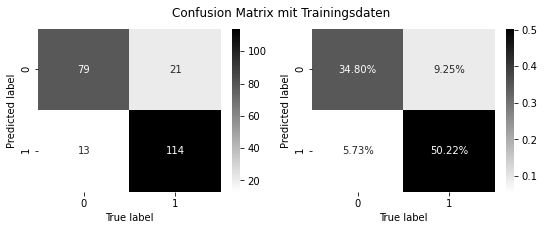

Richtig klassifiziert: 81.58%
Falsch klassifiziert: 18.42%


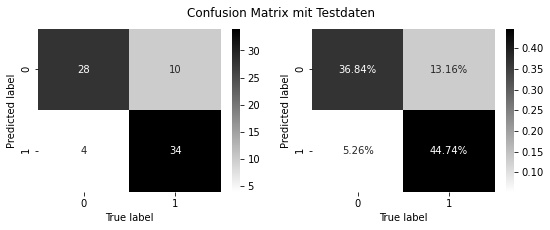

In [16]:
print(clf)
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)), "Confusion Matrix mit Trainingsdaten")
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)), "Confusion Matrix mit Testdaten")

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_test_scaled = scaler.transform(np.array(X_test))
# Define the black box function to optimize.

def black_box_function(zeroWeight):
    """

    Parameters
    ----------
    zeroWeight: hyper parameter to optimize for
    """
    
    # KI trainieren
    model = svm.SVC(kernel="linear", C=optimizer_acc.max["params"].get("C"), class_weight={0: zeroWeight, 1: 1})
    model.fit(X_train, y_train)
    matrix = confusion_matrix(y_train, model.predict(X_train))
    
    true_negative = matrix[0][0]
    true_positive = matrix[1][1]
    false_negative = matrix[0][1]
    false_negative_relative = false_negative / matrix.sum()
    accuracy = (true_positive + true_negative) / matrix.sum()
    
    # accuracy wird mit berücksichtigt, um zu verhindern, dass alle Herzpatienten sind
    gewichtung = .5 # getestet, liefert gute Ergebnisse
    f = gewichtung * accuracy + (1 - gewichtung) * (1 - false_negative_relative) # Gegenwert zur 1, weil maximiert wird
    return f

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"zeroWeight": [1, 5]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer_weight = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2
                                 )
optimizer_weight.maximize(init_points = 10, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer_weight.max["params"], optimizer_weight.max["target"]))

|   iter    |  target   | zeroWe... |
-------------------------------------
|  1        |  0.8678   |  4.848    |
|  2        |  0.8722   |  4.548    |
|  3        |  0.8877   |  2.096    |
|  4        |  0.8789   |  1.163    |
|  5        |  0.8634   |  4.53     |
|  6        |  0.8722   |  4.545    |
|  7        |  0.8833   |  2.462    |
|  8        |  0.8789   |  1.392    |
|  9        |  0.8943   |  2.949    |
|  10       |  0.8833   |  1.942    |
|  11       |  0.8921   |  2.965    |
|  12       |  0.8833   |  2.462    |
|  13       |  0.8943   |  2.923    |
|  14       |  0.9009   |  2.891    |
|  15       |  0.8987   |  2.864    |
|  16       |  0.8987   |  2.824    |
|  17       |  0.8921   |  2.785    |
|  18       |  0.8965   |  2.722    |
|  19       |  0.8987   |  2.68     |
|  20       |  0.8899   |  2.638    |
Best result: {'zeroWeight': 2.8913891640904694}; f(x) = 0.9008810572687225.


In [18]:
clf = svm.SVC(C = optimizer_acc.max["params"].get("C"), kernel = "linear", class_weight={0: optimizer_weight.max["params"].get("zeroWeight"), 1: 1})
clf.fit(data, output)

SVC(C=81.28215524449597, class_weight={0: 2.8913891640904694, 1: 1},
    kernel='linear')

Richtig klassifiziert: 81.06%
Falsch klassifiziert: 18.94%


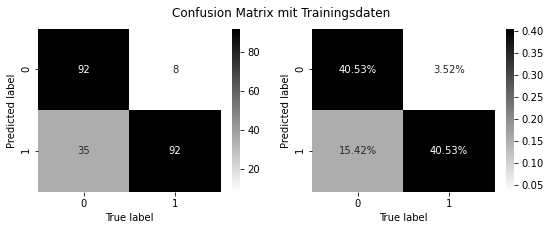

Richtig klassifiziert: 80.26%
Falsch klassifiziert: 19.74%


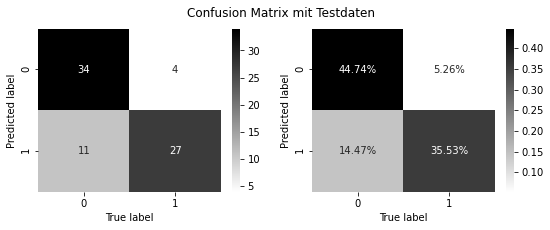

In [19]:
plot_confusion_matrix(confusion_matrix(y_train, clf.predict(X_train)), "Confusion Matrix mit Trainingsdaten")
plot_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)), "Confusion Matrix mit Testdaten")

In [20]:
k=10
model = svm.SVC(C = optimizer_acc.max["params"].get("C"), kernel = "linear", class_weight={0: optimizer_weight.max["params"].get("zeroWeight"), 1: 1})
model.fit(X_train, y_train)
scores = cross_val_score(model, data, output, cv=k)
scores.mean()

0.7655913978494624